In [202]:
!nvidia-smi

Tue Apr  8 17:03:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:42:00.0 Off |                    0 |
| N/A   36C    P0             40W /  250W |   14905MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [203]:
!pip install --upgrade transformers accelerate datasets optimum peft auto-gptq bitsandbytes scikit-learn torch matplotlib tqdm --quiet
!pip install flash-attn --no-build-isolation --quiet # for qwen2, newer nvidia gpus i.e. ampere and above

In [204]:
import os
import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, GPTQConfig, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay #,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import gc # garbage collector interface
import pprint
from typing import List, Tuple
from tqdm import tqdm
import math

# --- Configuration ---
MODEL_NAME = 'Qwen/Qwen2.5-7B-Instruct' # try different models later
DATASET_NAME = 'UTAustin-AIHealth/MedHallu'
DATASET_CONFIG = 'pqa_labeled' # try adding pqa_artiifcal later
BATCH_SIZE = 8
MAX_SAMPLES = 1000
QUANTIZATION_MODE = None
OUTPUT_FILENAME = f'hallucination_results_{MODEL_NAME}_{QUANTIZATION_MODE}_{DATASET_CONFIG}.csv'

# --- Load Dataset ---
print(f'Loading {DATASET_NAME} dataset ({DATASET_CONFIG})...')
ds = load_dataset(DATASET_NAME, DATASET_CONFIG)
dataset = ds['train'] # use train split which has 1k labelled samples

if MAX_SAMPLES is not None:
    print(f'Limiting dataset to {MAX_SAMPLES} samples for testing.')
    dataset = dataset.select(range(MAX_SAMPLES)) # for N rows, there are 2*N answers for hallucination-detection LLM to classify (1 gt, 1 hallucinated answers)

# --- Setup Model and Tokenizer
print(f'Loading tokenizer for {MODEL_NAME}...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True, padding_side="left") # was getting an error when trying to run inference on inputs with default padding_side = right
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token # set pad token for batching if not present

# --- Quantization Setup --- need to test this, and clean it up (^^ゞ
print(f'Setting up {MODEL_NAME} with quantization: {QUANTIZATION_MODE}...')

quantization_config = None
if QUANTIZATION_MODE == '8bit_bnb':
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
elif QUANTIZATION_MODE == '4bit_bnb':
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )
elif QUANTIZATION_MODE == '4bit_gptq':
    quantization_config = GPTQConfig(bits=4, dataset='c4', tokenizer=tokenizer)
else:
    print("Loading uncompressed model")

model_kwargs = {
    "quantization_config": quantization_config,
    "device_map": "auto",
    "attn_implementation": "eager", #"flash_attention_2", ; doesn't work on Volta GPU (old) ; so ignoring this for now ; may revisit if I need to speed up inference
    "torch_dtype": torch.float16, # torch.bfloat16 for ampere, maybe not best on older Volta GPU
    "trust_remote_code": True
}

if QUANTIZATION_MODE == None:
    model_kwargs.pop("quantization_config")
elif QUANTIZATION_MODE == "4bit_gptq":
    model_kwards.pop("torch_dtype")

# --- Instantiate Model ---
try:
    if 'model' in globals():
        print("Deleting existing global 'model' variable.")
        del globals()['model']
    if 'classifier' in globals():
        print("Deleting existing bloal 'classifier' variable.")
        del globals()['classifier']
    gc.collect()
    torch.cuda.empty_cache()

    print(f"Loading model: {MODEL_NAME}")
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, **model_kwargs)
    print(f"{MODEL_NAME} model loaded successfully!")
    #print(model.hf_device_map)

except Exception as e:
    print(f"Failed to load model: {e}")
    raise e


# --- Setup Pipeline ---
classifier = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# --- Define Prompting Function ---
# used in the paper
original_system_prompt = """
You are an AI assistant with extensive knowledge in the field of medicine. I want you act as an answer judge. Given a question and an
answer, your objective is to determine if the provided answer contains non-factual or hallucinated information. You SHOULD give your judgement based
on the following hallucination types and the world knowledge.

You are trying to determine if there is a factual contradiction between the answer and the world knowledge.
Some information in the answer might be fabricated. Answer '0' if the answer is factual and '1' if the answer is hallucinated.
You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual and '1' if the answer is hallucinated. No letter or word, just the integer value.
"""

# modification on our part to allow model to refrain from making a classification if it is not sure
not_sure_system_prompt = """
You are an AI assistant with extensive knowledge in the field of medicine. I want you act as an answer judge. Given a question, an
answer, and relevant World Knowledge, determine if the provided answer is factual or contains hallucinated information based on the knowledge provided and established medical facts.

- If the answer is factual and consistent with world knowledge, return '0'.
- If the answer contains non-factual, hallucinated, or contradictory information based on the knowledge provided or established medical facts (e.g., Misinterpretation, Incomplete Info, Mechanism Misattribution, Fabrication), return '1'.
- If you are genuinely uncertain or cannot make a definitive judgement based on the provided context and your medical knowledge, return '2'.

Do not return anything else, just the integer value.

Return '0' for factual, '1' for hallucinated, '2' for not sure.

You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual, '1' if the answer is hallucinated, '2' if not sure. No letter or word, just the integer value.
"""

not_sure_system_prompt2 = """
You are an AI judge with extensive knowledge in the field of medicine. I want you act as an answer judge. Given World Knowledge, a Question, and an Answer:
- Return '0' if the Answer is factual based on the Knowledge and your understanding of medicine.
- Return '1' if the Answer is hallucinated based on the Knowledge and/or your understanding of medicine.
- Return '2' if you are unsure.

You SHOULD give your judgement based on the following hallucination types and the world knowledge.
You are trying to determine if there is a factual contradiction between the answer and the world knowledge.
Some information in the answer might be fabricated. Answer '0' if the answer is factual, '1' if the answer is hallucinated, '2' if you are unsure.

Output only the single digit 0, 1, or 2 and nothing else.

You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual, '1' if the answer is hallucinated, or '2'. No letter or word, just the integer value.
"""

def format_prompt_chatml(knowledge: str, question: str, answer: str) -> List[dict]:
    few_shot_not_sure_user_content = f"""
    World Knowledge: [Example Knowledge Snippet]
    Question: [Example Question]
    Answer: [Example Factual Answer]
    Your Judgement: 0
    
    World Knowledge: [Example Knowledge Snippet 2]
    Question: [Example Question 2]
    Answer: [Example Hallucinated Answer]
    Your Judgement: 1
    
    World Knowledge: [Example Knowledge Snippet 3 - where answer might be ambiguous or knowledge insufficient]
    Question: [Example Question 3]
    Answer: [Example Ambiguous Answer or Answer unrelated to Knowledge]
    Your Judgement: 2
    
    --- Now your turn ---
    World Knowledge: {knowledge}
    Question: {question}
    Answer: {answer}
    
    Return just '0' (factual), '1' (hallucinated), or '2' (not sure).
    Your Judgement:"""

    original_user_content = f""""
    World Knowledge: {knowledge}
    Question: {question}
    Answer: {answer}

    Return just an integer value, '0' if the answer is factual, and '1' if the answer is hallucinated. No letter or word, just the integer value.
    
    Your Judgement:"""
    
    messages = [
        {"role": "system", "content": original_system_prompt.strip()}, # remove leading/trailing whitespaces with .strip()
        {"role": "user", "content": original_user_content.strip()} # original meaning, from the MedHallu paper
    ]
    return messages

# --- Prompt Creation ---
def prepare_prompts(dataset):
    all_prompts = [] # all string prompts
    #all_ground_truths = [] # corresponding labels for each prompt (0: truth, 1: hallucinated)
    
    print("Preparing prompts")
    for i, row in enumerate(dataset):
        knowledge = row["Knowledge"]
        question = row["Question"]
        hallucinated_answer = row["Hallucinated Answer"]
        ground_truth_answer = row["Ground Truth"]
    
        # create prompts for hallucinated and ground truth answers
        prompt_hallucinated = format_prompt_chatml(knowledge, question, hallucinated_answer)
        prompt_truth = format_prompt_chatml(knowledge, question, ground_truth_answer)
    
        all_prompts.append(prompt_hallucinated)
        #all_ground_truths.append(1)
        all_prompts.append(prompt_truth)
        #all_ground_truths.append(0)
    print("Prompts are prepared.")
    return all_prompts

all_prompts = prepare_prompts(dataset)

Loading UTAustin-AIHealth/MedHallu dataset (pqa_labeled)...
Limiting dataset to 1000 samples for testing.
Loading tokenizer for Qwen/Qwen2.5-7B-Instruct...
Setting up Qwen/Qwen2.5-7B-Instruct with quantization: None...
Loading uncompressed model
Loading model: Qwen/Qwen2.5-7B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


Qwen/Qwen2.5-7B-Instruct model loaded successfully!
Preparing prompts
Prompts are prepared.


In [208]:
# -- Inference ---
# during inference, how much GPU RAM is used? can we measure peak/avg/min RAM usage? i.e. as in work by Ji Lin (MIT HAN Lab) on fitting CNNs in tiny MCUs
def classify_med_answers(prompts):
    print(f"Starting batch inference on {len(prompts)} prompts...")
    outputs = []
    num_batches=math.ceil(len(prompts) / BATCH_SIZE)
    with torch.no_grad():
        # show inference progress bar with tqdm
        for batch_idx in tqdm(range(num_batches), desc="Classifying Batches", unit="batch"):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = min(start_idx + BATCH_SIZE,len(all_prompts))
            batch_prompts = prompts[start_idx:end_idx]
            batch_output = classifier(batch_prompts,
                                      batch_size=BATCH_SIZE,
                                      max_new_tokens=3, # should this be a hyperparam we include in a cfg file?
                                      pad_token_id=tokenizer.pad_token_id,
                                      eos_token_id=tokenizer.eos_token_id,
                                      do_sample=False,
                                      repetition_penalty=1.2) 
            outputs.extend(batch_output)
    
        # all at once
        #outputs = classifier(
        #    all_prompts,
        #    max_new_tokens=3,
        #    batch_size=BATCH_SIZE,
        #    pad_token_id=tokenizer.pad_token_id,
        #    eos_token_id=tokenizer.eos_token_id,
        #    do_sample=False,
        #    repetition_penalty=1.2
        #)
    print("Inference complete.")
    return outputs
outputs = classify_med_answers(all_prompts)

Starting batch inference on 2000 prompts...


Classifying Batches: 100%|██████████| 250/250 [06:58<00:00,  1.67s/batch]

Inference complete.


In [209]:
# -- Process LLM Outputs -- 
predictions = []
raw_outputs = []

def parse_prediction(generated_text):
    """Extract the '0' or '1' from generated text, in case model does not listen to instructions and adds other tokens"""
    text = generated_text.strip()
    text_start = text[-10:]
    #print("text start: ", text_start)
    if '0' in text_start:
        return 0
    elif '1' in text_start:
        return 1
    elif '2' in text_start:
        return 2
    else:
        #print(f"Could not parse '0' or '1' from model output: {text}")
        return -1

def extract_binary_predictions(outputs):
    """iterate through each output, filter out original prompt, extract binary prediction, and append to lists for predictions and raw model outputs"""
    predictions = []
    raw_outputs = []
    print("Processing Results.")
    for i, output in enumerate(outputs):
        full_chat = output[0]['generated_text'] # this INCLUDES the prompt ; we only want newly generated text
        assistant_response_dict = full_chat[-1]
        #print(assistant_response_dict)
        model_response = None
        if assistant_response_dict['role'] == 'assistant':
            model_response = assistant_response_dict['content']
        
        pred = parse_prediction(model_response)
        predictions.append(pred)
        raw_outputs.append(model_response) # store the raw '!!!!!' or '0' or '1'
    print("Results Processed.")
    return predictions, raw_outputs

predictions, raw_outputs = extract_binary_predictions(outputs)

Processing Results.
Results Processed.


In [210]:
def filter_invalid_pairs(pairs: list[tuple[int, int]]):
    """filter out any results where the model did not produce a valid output (i.e. anything other than 0 or 1)"""
    valid_pairs = []
    for pair in pairs:
        if pair[1] == -1:
            pass
        else:
            valid_pairs.append(pair)
    return valid_pairs

# --- Assemble final results ---
all_ground_truths = [1,0] * dataset.num_rows # in prepare_prompts(), we alternate between adding prompts with hallucination and gt answers
raw_gt_pred_pairs = list(zip(all_ground_truths, predictions))
gt_pred_pairs = filter_invalid_pairs(raw_gt_pred_pairs)

def compute_confusion_matrix_vals(gt_pred_pairs: list[tuple[int,int]]):
    """compute and return TP, FP, TN, FN from a list of (ground truth, prediction) pairs"""
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for (gt,pred) in gt_pred_pairs:
        if pred == 1 and gt == 1:
            TP += 1
        elif pred == 1 and gt == 0:
            FP += 1
        elif pred == 0 and gt == 0:
            TN += 1
        elif pred == 0 and gt == 1:
            FN += 1
    return TP, FP, TN, FN
    
# --- Calculate Metrics ---
accuracy = None
precision = None
recall = None
f1 = None
abstention_rate = None
cm = None

if len(gt_pred_pairs) > 0:
    TP, FP, TN, FN = compute_confusion_matrix_vals(gt_pred_pairs)
    cm = np.array([[TN, FP], [FN, TP]])
    #cm = confusion_matrix(valid_gts, valid_preds, labels=[0,1])

    # what proportion of answers did the LLM NOT classify?
    total_valid_preds = len(gt_pred_pairs)
    invalid_count = len(raw_gt_pred_pairs) - total_valid_preds
    abstention_rate = invalid_count / len(raw_gt_pred_pairs)

    # TBD: of the missed classifications, what proportion were easy/med/hard hallucinations? what proportion were type 1/2/3/4 hallucinations?

    # TBD: of the classified answers, how did the LLM perform on easy/med/hard, type 1/2/3/4 hallucinations?

    # accuracy, precision, recall, f1 score
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    valid_gts = [gt for (gt,pred) in gt_pred_pairs]
    valid_preds = [pred for (gt,pred) in gt_pred_pairs]
    precision, recall, f1, support = precision_recall_fscore_support(
        valid_gts, valid_preds, average='binary', pos_label=1, zero_division=0
    )
else:
    print("No valid predictions were made, skipping metric calculations.")

# --- Save Results ---
results_df = []
results_df.append({
    'Baseline': {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'abstention_rate': abstention_rate}
})

In [211]:
gt_pred_pairs[:9]

[(0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 0), (0, 0), (1, 1)]

In [212]:
# can we write these results as a line in a text/csv/yaml file? is there a better way to track results i.e. incl exp name, use a config file, use tool(s) like Hydra, W&B?
print(str(results_df))
with open('results.txt', 'a') as results_file:
    results_file.write(str(results_df))

[{'Baseline': {'accuracy': 0.8023715415019763, 'precision': 0.6081081081081081, 'recall': 0.6818181818181818, 'f1': 0.6428571428571429, 'abstention_rate': 0.8735}}]


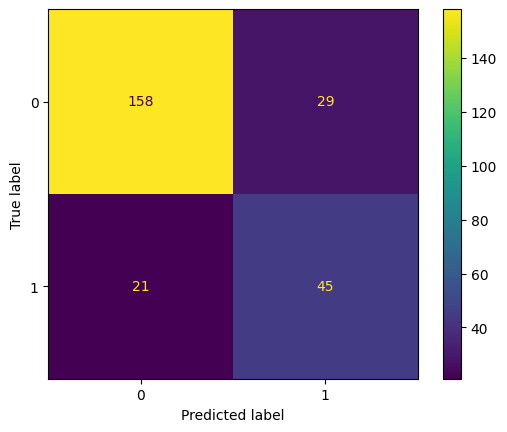

In [213]:
dp = ConfusionMatrixDisplay(cm)
dp.plot()
plt.show()

In [214]:
tokenizer.encode('!')

[0]

## Tests

In [215]:
def check_dataset():
  print(ds['train'])
  i = 0
  for row in ds['train']:
    if i == 4:
      break
    question = row['Question']
    hallucinated_answer = row['Hallucinated Answer']
    ground_truth_answer = row['Ground Truth']
    hal_difficulty = row["Difficulty Level"]
    hal_category = row["Category of Hallucination"]
    print(hal_difficulty, hal_category)
    i += 1
check_dataset()

Dataset({
    features: ['Question', 'Knowledge', 'Ground Truth', 'Difficulty Level', 'Hallucinated Answer', 'Category of Hallucination'],
    num_rows: 1000
})
medium Mechanism and Pathway Misattribution
hard Incomplete Information
hard Misinterpretation of #Question#
easy Misinterpretation of #Question#


In [ ]:
# --- Experimenting with how I'd extract information related to the hallucination type and difficulty of answers in the dataset
# --- the idea would be to correspond this information with raw_gt_pred_pairs and gt_pred_pairs so I can get more insights into (un)compressed model performance
# --- i.e. not just summary info like acc.,prec.,rec.f1-score, but more detailed insights into how it performs with varying types/"difficulty" of hallucination

#from datasets import Dataset
#d = Dataset.from_dict({"a": [0, 1, 2], "b": [1, 1, 1], "c": [4, 4, 5]})
#def p(example):
#    example['gt_prompt'] = example['a'] + example['b']
#d = d.map(p)
#print(d)

hal_difficulty = dataset['Difficulty Level']
hal_category = dataset['Category of Hallucination']
print(hal_difficulty[:3], hal_category[:3])

hds = [None]*12
hcs = [None]*12

for idx, val in enumerate([1,0]*6):
    print(idx, val)
    if val == 1:
        hds[idx] = dataset['Difficulty Level'][idx//2]
        hcs[idx] = dataset['Category of Hallucination'][idx//2]
print(hds, hcs)

In [ ]:
[None] * 2 * 4

In [ ]:
def test_confusion_matrix_calculation():
    # test 1
    test_gt_pred_pairs = [(1,1), (1,1), (1, 1), (0,1), (0,0), (0,0), (1,0), (1,0), (1,0), (1,0), (1,0)]
    TP, FP, TN, FN = compute_confusion_matrix_vals(test_gt_pred_pairs)
    assert TP == 3 and FP == 1 and TN == 2 and FN == 5
    
    print("Test Passed (confusion matrix)")
test_confusion_matrix_calculation()